In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D, Lambda, Input, Dense, concatenate
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

## small network for small dataset

In [30]:
def build_nin(activation, shape, classes, alpha=0.3):
    if activation == 'relu':
        activations = [ReLU() for _ in range(13)]

    elif activation == 'leaky_relu':
        activations = [LeakyReLU(alpha=alpha) for _ in range(13)]

    elif activation == 'prelu':
        activations = [PReLU() for _ in range(13)]

    input_layer = Input(shape)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
    x = activations[0](x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[1](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # second conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[2](x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[3](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # third conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[4](x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[5](x)
    x = Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = activations[6](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fourth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[7](x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[8](x)
    x = Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = activations[9](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fifth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[10](x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations[11](x)
    x = Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = activations[12](x)
    x = AveragePooling2D(pool_size=(5, 5))(x)
    x = Flatten()(x)
    output_layer = Dense(classes, activation=tf.nn.softmax)(x)

    model = Model(input_layer, output_layer)

    return model

In [31]:
def inception(x, filters, projection, activations, classes=None, aux=False, name=None, aux_name=None):
    f_1x1, f_3x3, f_3x3_reduce, f_5x5, f_5x5_reduce = filters
    a1, a2, a3, a4, a5, a6 = activations

    x1 = Conv2D(filters=f_1x1, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x1 = a1(x1)
    x3_reducer = Conv2D(filters=f_3x3_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x3_reducer = a2(x3_reducer)
    x5_reducer = Conv2D(filters=f_5x5_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x5_reducer = a3(x5_reducer)
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x3 = Conv2D(filters=f_3x3, kernel_size=(3, 3), strides=(1, 1), padding='same')(x3_reducer)
    x3 = a4(x3)
    x5 = Conv2D(filters=f_5x5, kernel_size=(5, 5), strides=(1, 1), padding='same')(x5_reducer)
    x5 = a5(x5)
    proj = Conv2D(filters=projection, kernel_size=(1, 1), strides=(1, 1), padding='same')(pool)
    proj = a6(proj)

    x = concatenate([x1, x3, x5, proj], axis=3, name=name)

    return x


def build_dw(activation, shape, classes, alpha=0.3):
    if activation == 'relu':
        activations_batch = [[ReLU() for _ in range(6)] for _ in range(9)]
        activations_single = [ReLU() for _ in range(3)]

    elif activation == 'leaky_relu':
        activations_batch = [[LeakyReLU(alpha=alpha) for _ in range(6)] for _ in range(9)]
        activations_single = [LeakyReLU(alpha=alpha) for _ in range(3)]

    elif activation == 'prelu':
        activations_batch = [[PReLU() for _ in range(6)] for _ in range(9)]
        activations_single = [PReLU() for _ in range(3)]

    input_layer = Input(shape)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
    x = activations_single[0](x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = activations_single[1](x)
    x = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = activations_single[2](x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [64, 128, 96, 32, 16], projection=32, activations=activations_batch[0], name='inception_3a')
    x = inception(x, [128, 192, 128, 96, 32], projection=64, activations=activations_batch[1], name='inception_3b')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception(x, [192, 208, 96, 48, 16], projection=64, activations=activations_batch[2], name='inception_4a')
    x = inception(x, [160, 224, 112, 64, 24], projection=64, activations=activations_batch[3], name='inception_4b')
    x = inception(x, [128, 256, 128, 64, 24], projection=64, activations=activations_batch[4], name='inception_4c')
    x = inception(x, [112, 288, 144, 64, 32], projection=64, activations=activations_batch[5], name='inception_4d')
    x = inception(x, [256, 320, 160, 128, 32], projection=128, activations=activations_batch[6], name='inception_4e')

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [256, 320, 160, 128, 32], projection=128, activations=activations_batch[7], name='inception_5a')
    x = inception(x, [384, 384, 192, 128, 48], projection=128, activations=activations_batch[8], name='inception_5b')
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Dropout(rate=0.4)(x)
    x = Flatten()(x)
    output_layer = Dense(classes, activation=tf.nn.softmax)(x)

    model = Model(input_layer, output_layer)

    return model

In [32]:
model_r = build_nin(activation='relu', shape=(96, 96, 3), classes=12)
model_lr_1 = build_nin(activation='leaky_relu', shape=(96, 96, 3), classes=12, alpha=5.5)
model_lr_2 = build_nin(activation='leaky_relu', shape=(96, 96, 3), classes=12, alpha=100)
model_pr = build_nin(activation='prelu', shape=(96, 96, 3), classes=12)

In [33]:
model_dw_r = build_dw(activation='relu', shape=(96, 96, 3), classes=12)
model_dw_lr_1 = build_dw(activation='leaky_relu', shape=(96, 96, 3), classes=12, alpha=5.5)
model_dw_lr_2 = build_dw(activation='leaky_relu', shape=(96, 96, 3), classes=12, alpha=100)
model_dw_pr = build_dw(activation='prelu', shape=(96, 96, 3), classes=12)

In [34]:
model_r.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_1030 (Conv2D)        (None, 96, 96, 64)        1792      
                                                                 
 re_lu_166 (ReLU)            (None, 96, 96, 64)        0         
                                                                 
 conv2d_1031 (Conv2D)        (None, 96, 96, 64)        36928     
                                                                 
 re_lu_167 (ReLU)            (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d_245 (MaxPooli  (None, 48, 48, 64)       0         
 ng2D)                                                           
                                                          

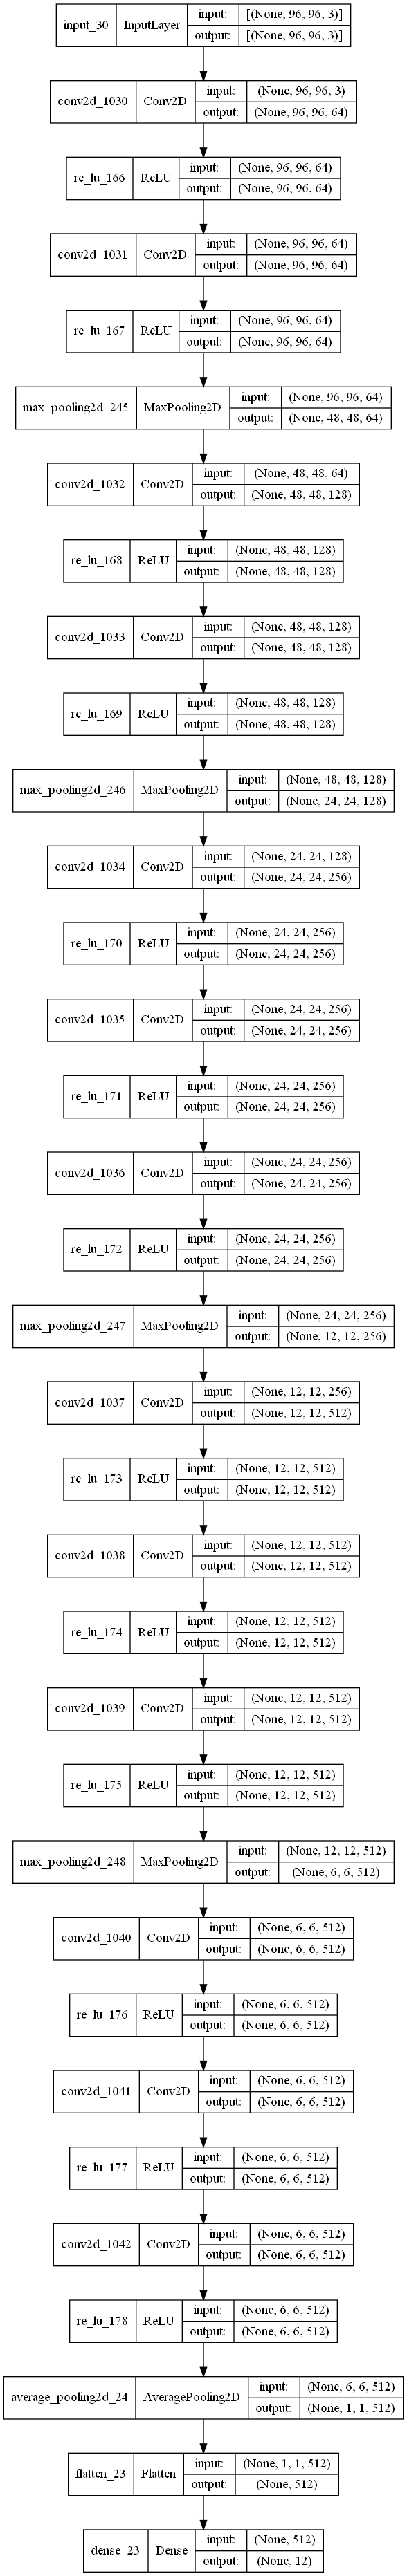

In [35]:
plot_model(model_r, to_file='nin_model.png', show_shapes=True, show_layer_names=True)

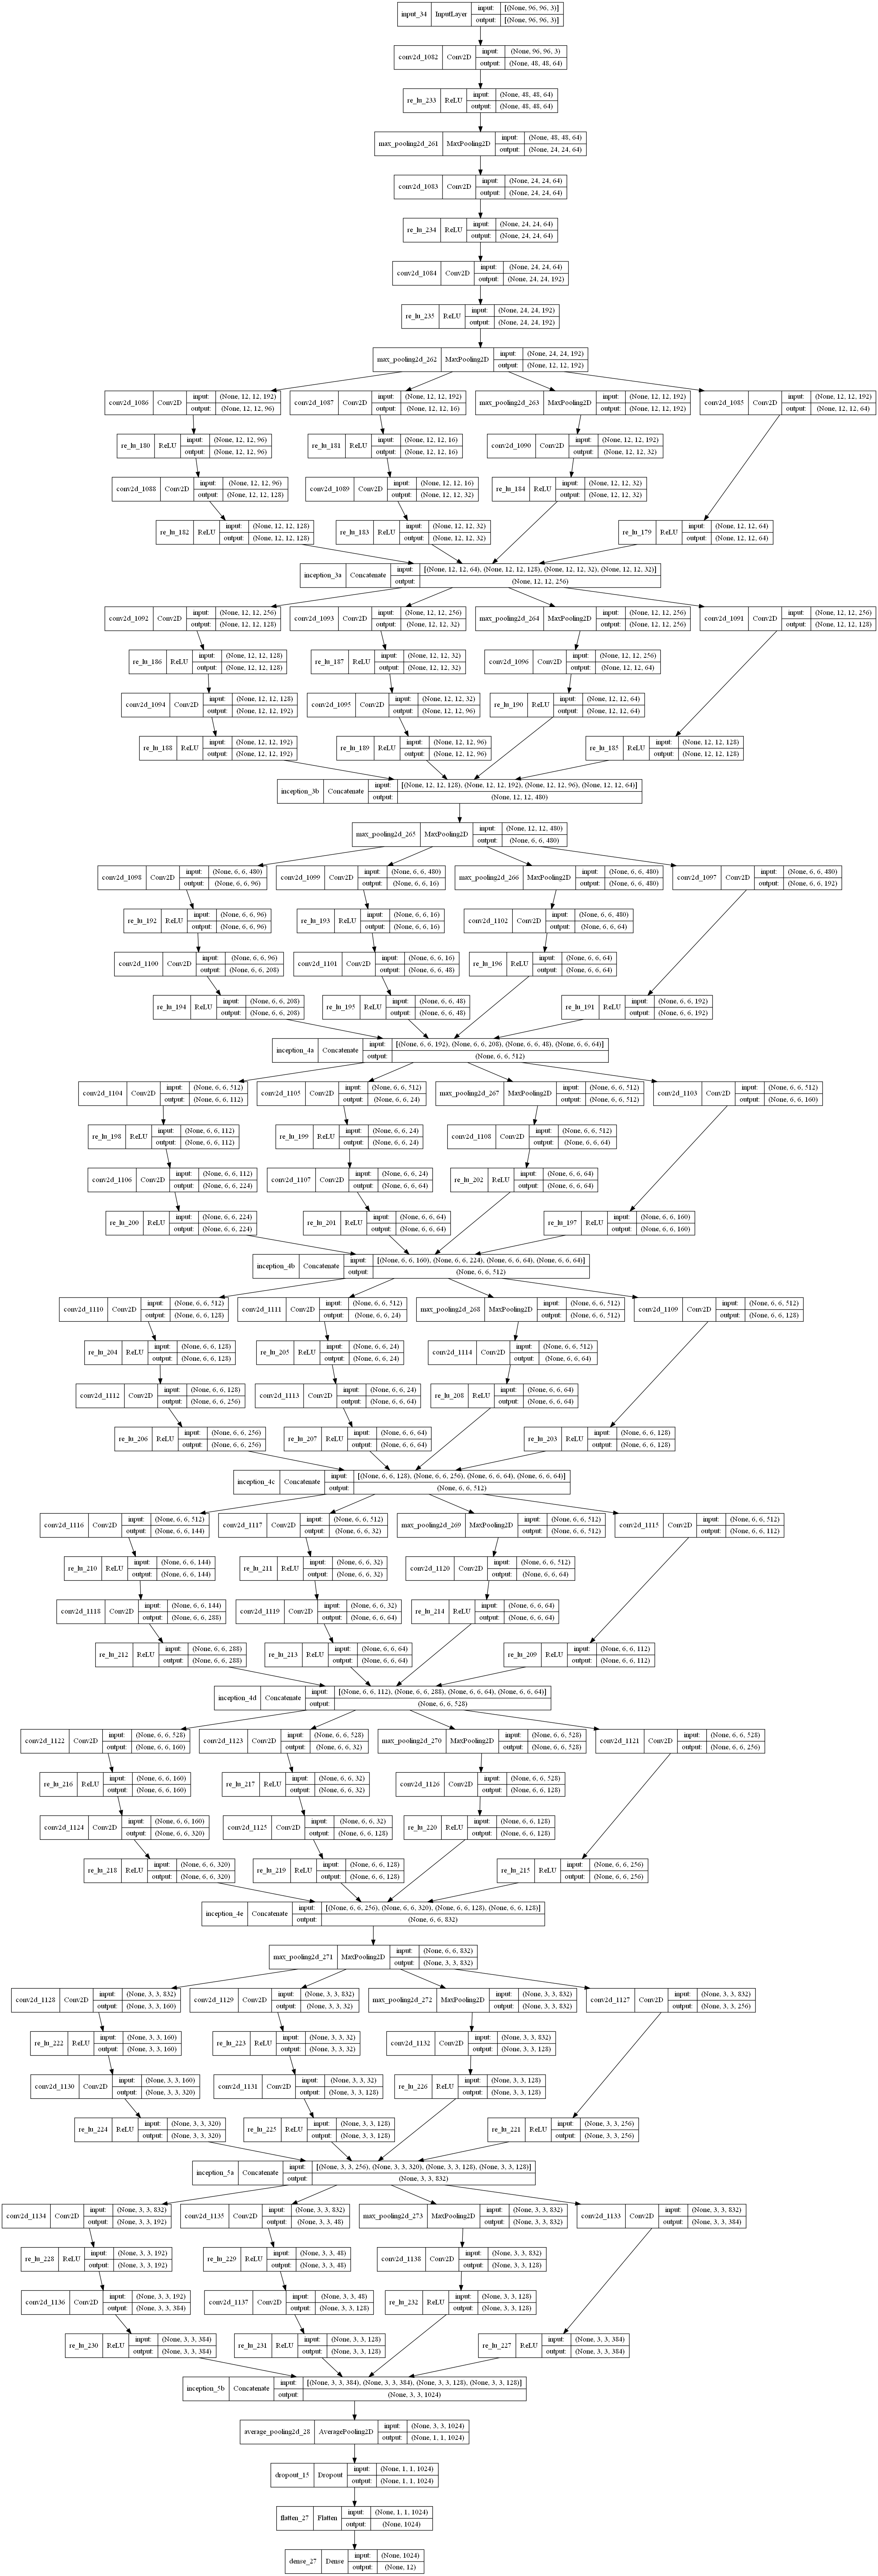

In [36]:
plot_model(model_dw_r, to_file='dw_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
generator = ImageDataGenerator(rescale=1 / 255.,
                               validation_split=0.2)

train_batch = generator.flow_from_directory(directory='',
                                            target_size=(64, 64),
                                            subset='training')

valid_batch = generator.flow_from_directory(directory='',
                                            target_size=(64, 64),
                                            subset='validation')

test_batch = generator.flow_from_directory(directory='',
                                           target_size=(64, 64))

In [ ]:
model_r.compile(optimizer=Adam(),
                loss=categorical_crossentropy,
                metrics=['accuracy'])

model_lr_1.compile(optimizer=Adam(),
                   loss=categorical_crossentropy,
                   metrics=['accuracy'])

model_lr_2.compile(optimizer=Adam(),
                   loss=categorical_crossentropy,
                   metrics=['accuracy'])

In [ ]:
model_r.fit(train_batch,
            epochs=100,
            validation_data=valid_batch)

In [ ]:
model_lr_1.fit(train_batch,
               epochs=100,
               validation_data=valid_batch)

In [ ]:
model_lr_2.fit(train_batch,
               epochs=100,
               validation_data=valid_batch)